## A/B - тестирование


Внутри увидите пример как формируются результаты по аб-тестированию. Прочтите сначала его, затем приступайте к выполнению задания.

В папке присутствует файл ab_test_ensembles.csv , который содержит реальные данные ab теста. Вам необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы такое же как и в примере, нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%, коэффициенты конверсии одинаковы с файлом из примера (плюс/минус) поэтому с этим проблем быть не должно. Условия гипотез теже.

В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:

1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Также необходимо провести небольшое EDA по представленному датасету, нарисовать два графика на ваш вкус.

---

**Баллы могут быть снижены** за качество кода - старайтесь чтобы код был максимально лаконичным. Названия переменных (если они используются) должны отражать максимальную ее сущность.

**Комментарии по сдаче практического задания**:
1. Залить в репу на github в папку module_2/ab_test_inference
2. Ссылку на репо отправлять мне на почту alexadevv@gmail.com не позднее дедлайна.
3. Тема письма: Домашнее задание по модулю 2 <Фамилия Имя>
4. После дедлайна, неотправленные на почту задания, оцениваются максимум в 7 баллов.

In [4]:
pip install statsmodels matplotlib


  Using cached statsmodels-0.14.6-cp314-cp314-win_amd64.whl.metadata (9.8 kB)
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.6 MB 1.1 MB/s eta 0:00:09
   --- ------------------------------------ 0.8/9.6 MB 1.0 MB/s eta 0:00:09
   --- ------------------------------------ 0.8/9.6 MB 1.0 MB/s eta 0:00:09
   ---- ----------------------------------- 1.0/9.6 MB 893.4 kB/s eta 0:00:10
   ---- ----------------------------------- 1.0/9.6 MB 893.4 kB/s eta 0:00:10
   ----- ---------------------------------- 1.3/9.6 MB 738.0 kB/s eta 0:00:12
   ----- ---------------------------------- 1.3/9.6 MB 738.0 kB/s eta 0:00:12
   ----- ---------------------------------- 1.3/9.6 MB 738.0 kB/s eta 0:00:12
   ----- ---------------------------------- 1.3/9.6 MB 738.0 kB/s eta 0:00:12
   ------ ---------

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil


## Дизайн эксперимента
Определим необходимый размер выборки для проведения нашего эксперимента и убедимся в том, что он достатчен для нашего исследования.

In [21]:
effect_size = sms.proportion_effectsize(0.13, 0.15)
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)
required_n = ceil(required_n)
print(F"Для каждой группы нам необходимо не меньше {required_n} наблюдений")


Для каждой группы нам необходимо не меньше 4720 наблюдений


## Сбор данных и подготовка


In [4]:
df = pd.read_csv('./ab_test_ensembles.csv')
df.head(10)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
5,426f77eb-8739-43b6-999c-aecd14d9f346,2022-05-10 15:20:49.083499,control,standard,0,United Kingdom,42-49,registered_user
6,aa9d93c5-a18f-444a-a522-7e7145835362,2022-05-19 03:26:46.940749,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,registered_user
7,de214e30-9b8d-44cf-87b1-16917f3e1c89,2022-05-17 01:48:29.539573,control,standard,0,United Kingdom,18-25,registered_user
8,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
9,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [28]:
df.user_type.value_counts()

user_type
registered_user    147240
new_user           147238
Name: count, dtype: int64

In [39]:
df.group.value_counts(normalize=True)

group
treatment    0.500126
control      0.499874
Name: proportion, dtype: float64

In [28]:
#проверим, сколько у нас значений для каждой групп: control - treatment, убедимся, что эти признаки находятся в достаточной количестве т.е больше 4720
df['group'].value_counts()
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")


У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [6]:
# Убедимся, что контрольная и испытуемая группы пользуются обоими вариантами работы сервиса
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [7]:
#проверим, сколько у нас значений для каждой групп: control - treatment, убедимся, что эти признаки находятся в достаточной количестве т.е больше 4720
df['group'].value_counts()


group
treatment    147276
control      147202
Name: count, dtype: int64

In [5]:
#Количество пользователей в контрольной и опытной группах разное, 
#поэтому сформируем одинаковое максимально  количество пользователей в каждой из групп случайным образом, учитывая необходимость 
#использовать всю выборку
control_sample = df[df['group'] == 'control'].sample(147202, random_state=42)
treatment_sample = df[df['group'] == 'treatment'].sample(147202, random_state=42)
# Сформируем общую случайную выборку
ab_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_df.reset_index(drop=True, inplace=True)
ab_df.head()


,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,bcf8452b-3056-4d45-994f-5f286fd9869a,2022-05-18 04:44:18.590293,control,standard,0,United Kingdom,42-49,new_user
1,3c827a98-0868-4ce5-ac31-8195e243af37,2022-05-14 05:22:43.771772,control,standard,0,United Kingdom,50-57,new_user
2,71c72bb9-13d9-4755-b398-b2c5d8b1c4d6,2022-05-23 08:52:53.050325,control,standard,0,United Kingdom,34-41,new_user
3,654ee878-b0c5-4223-b9fb-995ca3d2eaf1,2022-05-07 23:27:09.109877,control,standard,0,United Kingdom,26-33,registered_user
4,1e044366-7e86-4d92-bba7-3afaa6f887f8,2022-05-20 14:26:10.133979,control,standard,0,United Kingdom,42-49,new_user


In [17]:
ab_df.info() все user_id уникальны, пропущенных знаячений нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294404 entries, 0 to 294403
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294404 non-null  object
 1   timestamp  294404 non-null  object
 2   group      294404 non-null  object
 3   variants   294404 non-null  object
 4   converted  294404 non-null  int64 
 5   location   294404 non-null  object
 6   age_group  294404 non-null  object
 7   user_type  294404 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [11]:
ab_df.group.value_counts(normalize=True)#убедимся, что количество одинаково

group
control      0.5
treatment    0.5
Name: proportion, dtype: float64

In [16]:
ab_df.isnull().sum()#убед

user_id      0
timestamp    0
group        0
variants     0
converted    0
location     0
age_group    0
user_type    0
dtype: int64

In [24]:
ab_df.converted.value_counts()

converted
0    259177
1     35227
Name: count, dtype: int64

In [26]:
ab_df.age_group.value_counts()

age_group
26-33    49261
50-57    49215
58+      49173
42-49    49108
34-41    48883
18-25    48764
Name: count, dtype: int64

In [27]:
ab_df.user_type.value_counts()

user_type
new_user           147202
registered_user    147202
Name: count, dtype: int64

## Визуализация результатов эксперимента. Рассчитаем выборочные статистики: стандартное отклонение sdt, среднее mean и ошибку среднего sem  чтобы понять каково распределение данных и как выглядят наши выборки

In [35]:
conversion_rates = ab_df.groupby('group')['converted']
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21100\1611041459.py:6: FutureWarning: The provided callable <function mean at 0x0000021FC9019A60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})


,CR mean,CR std,CR se
group,,,
control,0.120399,0.325428,0.000848
treatment,0.118911,0.323684,0.000844


C:\Users\ASUS\AppData\Local\Temp\ipykernel_29604\70975740.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ab_df['group'], y=ab_df['converted'], palette="pastel", errorbar=('ci', False))


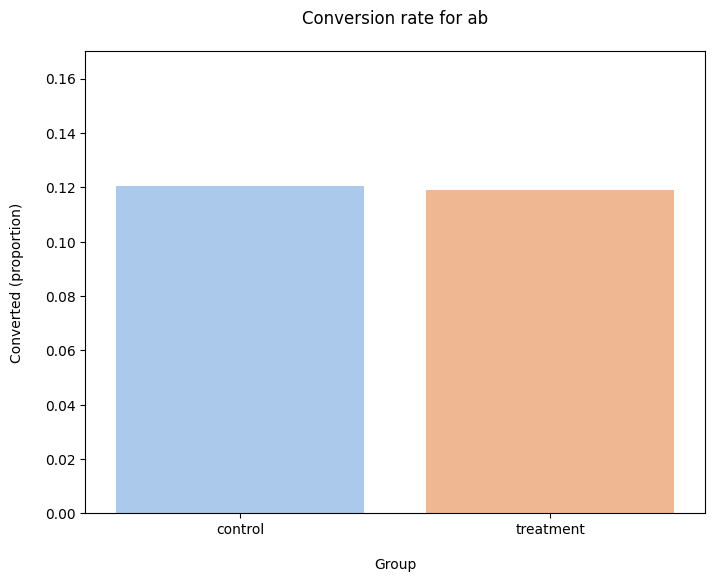

In [12]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_df['group'], y=ab_df['converted'], palette="pastel", errorbar=('ci', False))
plt.ylim(0, 0.17);
plt.title('Conversion rate for ab', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);
plt.show()


In [ ]:
Н0-гипотеза - работаем со  сервисом и ничего не меняем, Н1 - заменяем на новый .

## Тестирование гипотезы
По результатм теста мы должны ответиить на воспрос: действительно ли разница статистически значимой. Поскольку наша выборка гораздо больше 30, будем использовать нормальную аппроксимацию - рассчитаем  p-статистику (Z-test).

In [13]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_df[ab_df['group'] == 'control']['converted']
treatment_results = ab_df[ab_df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.24
p-value: 0.214
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.121]


In [ ]:
Так как наше p-значение = 0.214 что является высоким показателем по сравнению с выбранной альфой 0.05, то согласно статистическому выводу, мы не
можем отклонить нулевую гипотезу H0, что означает наш новый сервис -  svm_ensemble_v_1_22 никак статистически значимо не влияет на уровень конверсии
и повышение уровня конверсии - это случайность.

Доверительный интервал для испытуемой группы [0.119, 0.122] или 11% и 12% соответственно:

Он включает наш baseline
Он не достигает нашей цели 15%
Мы можем интерпретировать это как - наиболее вероятно, что реальный уровень конверсии сайта с новым дизайном будет близок к baseline чем к 15%,
который мы определили по нашей цели.
    Таким образом у нас два варианта:
    - Можно создать новую версию сервиса (потратить время, деньги) и опять протестировать, надо решать стоят ли затраты на новую версию 2% улучшения 
    -Ничего не менять.